In [1]:
#this is a data cleaning jupyter notebook on horse racing data

import pandas as pd
import numpy as np
import regex
import time
import os
import seaborn as sns
import matplotlib.pyplot as plt
%pwd

'/home/neilfa/jupyter_data_cleaning'

In [2]:
with open('/proc/meminfo') as file:
    for line in file:
        if 'MemFree' in line:
            free_mem_in_kb = line.split()[1]
            break
file_path = '2019_1_1-2020_1_1.csv' 
file_size = os.path.getsize(file_path)
            
start = time.time()
df = pd.read_csv(file_path)
end = time.time()
index = df.index
num_row = len(index)

print('It takes {0} seconds to load in {1} rows of data (size of the file is {2} bytes), with {3} memory available'.format((end-start),num_row,file_size,free_mem_in_kb))

It takes 0.22293567657470703 seconds to load in 31651 rows of data (size of the file is 14016826 bytes), with 11781320 memory available


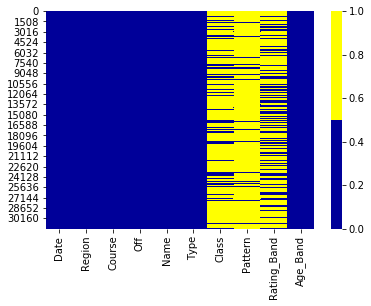

In [3]:
# missing values analysis

cols = df.columns[:10] # first 30
colours = ['#000099', '#ffff00'] # specify the colours - yellow is missing. blue is not missing.
sns.heatmap(df[cols].isnull(), cmap=sns.color_palette(colours))

#normal for class to have missing values as Ireland races don't have a class




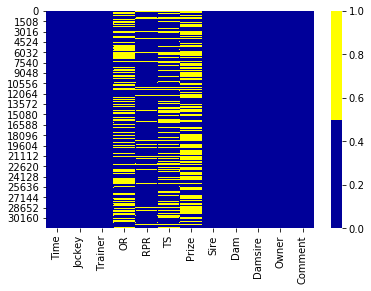

In [4]:

cols = df.columns[30:42] # last 12
colours = ['#000099', '#ffff00'] # specify the colours - yellow is missing. blue is not missing.
sns.heatmap(df[cols].isnull(), cmap=sns.color_palette(colours))

In [5]:
# Gonna make a smaller dataframe (sm_df)
# Just to make it easier to work with

sm_df = df.loc[:,('Date','Off','Name','Horse','Pos','SP','Ran','Time','RPR',)]
sm_df.head()

,Date,Off,Name,Horse,Pos,SP,Ran,Time,RPR
0,2019-01-01,12:20,Happy New Year from all at Fairyhouse Maiden H...,Swordsman (IRE),1,3/1,15,5:1.80,127.0
1,2019-01-01,12:20,Happy New Year from all at Fairyhouse Maiden H...,Westport Lady (FR),2,8/1,15,5:4.20,111.0
2,2019-01-01,12:20,Happy New Year from all at Fairyhouse Maiden H...,Momus (IRE),3,10/11F,15,5:5.15,115.0
3,2019-01-01,12:20,Happy New Year from all at Fairyhouse Maiden H...,Tara Mill (IRE),4,25/1,15,5:5.40,112.0
4,2019-01-01,12:20,Happy New Year from all at Fairyhouse Maiden H...,Impatient Partner (IRE),5,8/1,15,5:5.70,111.0


In [6]:
# sorting out the fractional odds to decimal odds, and having a new column saying if they are favourite
# decimal odds are easier to work with 
# decimal odds = numerator / denominator + 1

fodds = df.loc[:,'SP'] #fractional odds
fodds = fodds.str.replace("Evens","1/1")
fodds = fodds.str.replace("Evs","1/1")
splt = fodds.str.extract(r'(\d+).(\d+)(.?)')

splt.iloc[:,0] = splt.iloc[:,0].astype(float)
splt.iloc[:,1] = splt.iloc[:,1].astype(float)

dodds = (splt.iloc[:,0]/splt.iloc[:,1])+1 #decimal odds

odds_f = pd.concat([dodds,splt.iloc[:,2]],axis=1)

sm_df.loc[:,'SP'] = odds_f.iloc[:,0]
sm_df = pd.concat([sm_df,odds_f.iloc[:,1]],axis=1)


sm_df=sm_df.rename(columns={2:"Fav"})

#There are 3 possible letters that can come after the odds:
#F there is one favourite in the race (7/2F)
#J there are 2 favourite in the race (same odds) (7/2J,7/2J)
#C there are 3 favourite (3/1C,3/1C,3/1C)

#Instead of keeping the letters
#Gonna make a new column with series of bool - favorite TRUE or FALSE

sm_df.loc[:,"Fav"] = sm_df.loc[:,"Fav"].str.contains(r"\S") 

sm_df.head()





,Date,Off,Name,Horse,Pos,SP,Ran,Time,RPR,Fav
0,2019-01-01,12:20,Happy New Year from all at Fairyhouse Maiden H...,Swordsman (IRE),1,4.000000,15,5:1.80,127.0,False
1,2019-01-01,12:20,Happy New Year from all at Fairyhouse Maiden H...,Westport Lady (FR),2,9.000000,15,5:4.20,111.0,False
2,2019-01-01,12:20,Happy New Year from all at Fairyhouse Maiden H...,Momus (IRE),3,1.909091,15,5:5.15,115.0,True
3,2019-01-01,12:20,Happy New Year from all at Fairyhouse Maiden H...,Tara Mill (IRE),4,26.000000,15,5:5.40,112.0,False
4,2019-01-01,12:20,Happy New Year from all at Fairyhouse Maiden H...,Impatient Partner (IRE),5,9.000000,15,5:5.70,111.0,False


In [7]:
#New horse name with only the name
#New column with the horse's country

nme = sm_df.loc[:,'Horse']
splt = nme.str.extract(r"(.+)\s\((\w+)\)")
sm_df['Horse'] = splt.iloc[:,0]
sm_df['Horse_nation'] = splt.iloc[:,1]
sm_df.head(15)



,Date,Off,Name,Horse,Pos,SP,Ran,Time,RPR,Fav,Horse_nation
0,2019-01-01,12:20,Happy New Year from all at Fairyhouse Maiden H...,Swordsman,1,4.000000,15,5:1.80,127.0,False,IRE
1,2019-01-01,12:20,Happy New Year from all at Fairyhouse Maiden H...,Westport Lady,2,9.000000,15,5:4.20,111.0,False,FR
2,2019-01-01,12:20,Happy New Year from all at Fairyhouse Maiden H...,Momus,3,1.909091,15,5:5.15,115.0,True,IRE
3,2019-01-01,12:20,Happy New Year from all at Fairyhouse Maiden H...,Tara Mill,4,26.000000,15,5:5.40,112.0,False,IRE
4,2019-01-01,12:20,Happy New Year from all at Fairyhouse Maiden H...,Impatient Partner,5,9.000000,15,5:5.70,111.0,False,IRE
5,2019-01-01,12:20,Happy New Year from all at Fairyhouse Maiden H...,The Echo Boy,6,11.000000,15,5:11.30,85.0,False,IRE
6,2019-01-01,12:20,Happy New Year from all at Fairyhouse Maiden H...,Galboystown Rose,7,101.000000,15,5:14.30,60.0,False,IRE
7,2019-01-01,12:20,Happy New Year from all at Fairyhouse Maiden H...,Robbies Magic,8,101.000000,15,5:16.30,58.0,False,IRE
8,2019-01-01,12:20,Happy New Year from all at Fairyhouse Maiden H...,Take A Turn,9,26.000000,15,5:17.10,51.0,False,IRE
9,2019-01-01,12:20,Happy New Year from all at Fairyhouse Maiden H...,Goodkess,10,34.000000,15,5:24.50,17.0,False,IRE


In [8]:
#Now I need to convert time from string to actual time in seconds
#5:1.80 = 5min and 1.8 seconds
print(type(sm_df.loc[0,'Time']))
tme = sm_df['Time']
mtch = tme.str.extract(r"(\d+):(.+)")
mtch[0] = mtch[0].astype(float)
mtch[1] = mtch[1].astype(float)
sm_df['Time'] = (mtch[0]*60)+mtch[1]
#sm_df.iloc[[0,15],:]
sm_df.head()

<class 'str'>


,Date,Off,Name,Horse,Pos,SP,Ran,Time,RPR,Fav,Horse_nation
0,2019-01-01,12:20,Happy New Year from all at Fairyhouse Maiden H...,Swordsman,1,4.000000,15,301.80,127.0,False,IRE
1,2019-01-01,12:20,Happy New Year from all at Fairyhouse Maiden H...,Westport Lady,2,9.000000,15,304.20,111.0,False,FR
2,2019-01-01,12:20,Happy New Year from all at Fairyhouse Maiden H...,Momus,3,1.909091,15,305.15,115.0,True,IRE
3,2019-01-01,12:20,Happy New Year from all at Fairyhouse Maiden H...,Tara Mill,4,26.000000,15,305.40,112.0,False,IRE
4,2019-01-01,12:20,Happy New Year from all at Fairyhouse Maiden H...,Impatient Partner,5,9.000000,15,305.70,111.0,False,IRE


In [9]:
#There is an important error to fix
#The name of a race might be duplicated ie, the same named race can occur on 2 different dates
#What needs to be done:
#1. Need to create a column identifying whether or not the race is a handicapped
    #creating a new bool series identicating whether the race is handicapped or not might be useful for analysis
#2. Create a new unique set of IDs for the race:
    # how to do this step I'm not sure

pattern = "andica"
sm_df['Handicap'] = sm_df['Name'].str.contains(pattern)


pattern2 = "aiden"
sm_df['Maiden_race'] = sm_df['Name'].str.contains(pattern2)
#total number of races = group by date, time of race(Off) and name
#ie. impossible for 2 race to occur at the same time on the same day with the same name


grpDN = sm_df.groupby(['Date','Off','Name']) 
grpN = sm_df.groupby(['Name'])
print("there are {} races with the same name\ntotal number of races is {} in 2019".format((grpDN.ngroups-grpN.ngroups),grpDN.ngroups))


there are 406 races with the same name
total number of races is 2677 in 2019


In [10]:
#Creating a Unique ID for each race (UID)
#year(2019) + the index number (could be alphabetical) not important as long as the UID

UID = list()
racesnu = grpDN.ngroups
for i in range(racesnu):
    UID.append('2019'+(str(i+1)))

#append value to a already excisting key
#https://thispointer.com/python-how-to-add-append-key-value-pairs-in-dictionary-using-dict-update/#:~:text=this'%3A%2043%7D-,Append%20multiple%20key%20value%20pair%20in%20dictionary,it%20will%20update%20its%20value.
def append_value(dict_obj, key, value):
    # Check if key exist in dict or not
    if key in dict_obj:
        # Key exist in dict.
        # Check if type of value of key is list or not
        if not isinstance(dict_obj[key], list):
            # If type is not list then make it list
            dict_obj[key] = [dict_obj[key]]
        # Append the value in list
        dict_obj[key].append(value)
    else:
        # As key is not in dict,
        # so, add key-value pair
        dict_obj[key] = value    


#Still trying to find a way to easily assign UIDs
#Trying not to do any real complicated loops
#If you look at the pattern of 'Ran'
#it looks something like 3,3,3,4,4,4,4,2,2
#if I turn that list into 3,4,2 , Ie  first race 3 ran 2nd race 4 ran etc
#Then i can create a list that goes like:
    #repeat UID 3 times then repeat the next UID 4 times etc

lsRan = list(sm_df['Ran'])

for i, x in enumerate(lsRan):
    del lsRan[i+1:i+x]

#the loop below confirms that there is in fact 2677 not 2663
cnt =0 
test = dict(sm_df['Ran'].value_counts())
for keys in test:
    cnt += (test[keys]/keys)

lsUID = [] #list of all the UIDs that can go in the dataframe
for i in range(len(UID)):
    lc = [UID[i]]*lsRan[i]
    for j in lc:
        lsUID.append(j)
sm_df['UID']=lsUID

#Now each race a UID



In [11]:
#Still trying to find a way to easily assign UIDs
#Trying not to do any real complicated loops
#If you look at the pattern of 'Ran'
#it looks something like 3,3,3,4,4,4,4,2,2
#if I turn that list into 3,4,2 , Ie  first race 3 ran 2nd race 4 ran etc
#Then i can create a list that goes like:
    #repeat UID 3 times then repeat the next UID 4 times etc

lsRan = list(sm_df['Ran'])

for i, x in enumerate(lsRan):
    del lsRan[i+1:i+x]

#the loop below confirms that there is in fact 2677 not 2663
cnt =0 
test = dict(sm_df['Ran'].value_counts())
for keys in test:
    cnt += (test[keys]/keys)

lsUID = []
for i in range(len(UID)):
    lc = [UID[i]]*lsRan[i]
    for j in lc:
        lsUID.append(j)


        


/usr/lib/python3/dist-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


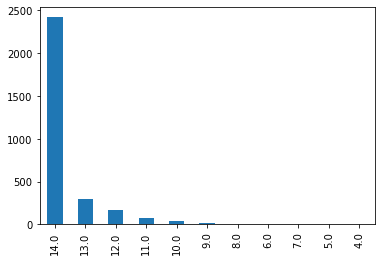

In [12]:
#Need to explore the RPR

#Hypothesis = Ones with no RPR will mostly always be towards the end
#Firstly need to sort out the position column

sm_df['true_Pos']=sm_df['Pos']
pos = sm_df.loc[:,('true_Pos')]
for i in range(len(pos)):
    try:
        int(pos[i])
    except:
        pos.iloc[i]=sm_df.loc[i,'Ran']

sm_df['true_Pos'] = pd.to_numeric(sm_df['true_Pos'])


RprBool = pd.isna(sm_df['RPR'])
TotalNan = sm_df[RprBool]


#Now need to evaluate if no RPR correlates to bottom position
#Because 5th position from 5 runners is the same as 12th from 12
#I need to normalise the positions, so that they all ressemble 10 horse race
#formula: (pos / ran) * 10 
normPos = list()
tot = sm_df.shape[0]
for i in range(tot):
    tP = sm_df.loc[i,'true_Pos']
    ran = sm_df.loc[i,'Ran']
    val = (tP/ran)*14
    normPos.append(val)
sm_df['normPos'] = normPos

sm_df['RprBool']=RprBool

RvP = sm_df.loc[:,('RprBool','normPos')]
RvP['normPos'] = RvP['normPos'].round()
RvPt = RvP[(RvP['RprBool']==True)]
RvPf = RvP[(RvP['RprBool']==False)]
vc = RvPt['normPos'].value_counts()
RvPhis = vc.plot(kind='bar')

#This graph shows you that indeed if the horse does not have an RPR
#It will most likely finish in a bottom position

















In [13]:
#Need to know to a basic correlation graph
#btwn: RPR and position
#RPR varies between races
#Need to know if IN GENERAL high RPR results in a better position outcome

#ln = sm_df.shape[0]


def difRPR(ser):
    ser = pd.to_numeric(ser)
    mx = ser.max()
    ln = len(ser)
    res = [mx]*ln
    return res-ser


races = sm_df.groupby('UID').groups

Races = sm_df.loc[:,'UID'].unique()

nas = np.empty((1,sm_df.shape[0]))
nas[:] = np.nan
sm_df['difRPR'] = nas[0]
RPRdic = {}
RPRdicH = {}
RPRdicNH = {}

#races[Races[1]][1]
for i in Races:
    
    dfr = sm_df.loc[races[i],'RPR']
    ln = len(dfr)
    mn = dfr.min()    
    dfr = dfr.fillna(mn)
    dfr = pd.to_numeric(dfr)
    #RPRdic[i] = difRPR(dfr)
    sm_df.loc[races[i],'difRPR'] = difRPR(dfr)
    if sm_df.loc[races[i][0],'Ran'] == 14 and sm_df.loc[races[i][0],'Handicap'] == True:
        RPRdicH[i] = difRPR(dfr).values.tolist()
    elif sm_df.loc[races[i][0],'Ran'] == 14 and sm_df.loc[races[i][0],'Handicap'] == False:
        RPRdicNH[i] = difRPR(dfr).values.tolist()
        
    
#dfr = sm_df.loc[races[Races[0]],'RPR']

#sm_df.loc[:,('difRPr','RPR')]
#sm_df.loc[races['20191'],'RPR'].min() 
       
#difRPR(sm_df.loc[races['201911'],'RPR'])

#sm_df.loc[:,'difRPR'].replace(races[Races[0]],difRPR(pd.to_numeric(sm_df.loc[races[Races[0]],'RPR'].fillna(17))),inplace=True)
#sm_df.loc[:,'difRPR']


In [14]:
RPRdicNH

{'201910': [3.0,
  5.0,
  0.0,
  17.0,
  24.0,
  20.0,
  33.0,
  37.0,
  48.0,
  41.0,
  43.0,
  64.0,
  64.0,
  64.0],
 '201917': [0.0,
  2.0,
  3.0,
  12.0,
  21.0,
  27.0,
  24.0,
  28.0,
  33.0,
  32.0,
  37.0,
  44.0,
  50.0,
  74.0],
 '201925': [1.0,
  0.0,
  5.0,
  9.0,
  28.0,
  25.0,
  65.0,
  69.0,
  69.0,
  69.0,
  5.0,
  69.0,
  69.0,
  69.0],
 '201978': [0.0,
  9.0,
  17.0,
  28.0,
  29.0,
  44.0,
  48.0,
  51.0,
  71.0,
  74.0,
  82.0,
  107.0,
  107.0,
  107.0],
 '2019113': [0.0,
  5.0,
  6.0,
  7.0,
  10.0,
  11.0,
  13.0,
  13.0,
  14.0,
  15.0,
  17.0,
  17.0,
  19.0,
  19.0],
 '2019131': [0.0,
  7.0,
  13.0,
  20.0,
  18.0,
  22.0,
  24.0,
  27.0,
  27.0,
  37.0,
  81.0,
  92.0,
  92.0,
  92.0],
 '2019140': [5.0,
  7.0,
  0.0,
  17.0,
  18.0,
  11.0,
  24.0,
  28.0,
  22.0,
  23.0,
  37.0,
  38.0,
  32.0,
  65.0],
 '2019193': [0.0,
  13.0,
  27.0,
  23.0,
  22.0,
  23.0,
  44.0,
  42.0,
  53.0,
  50.0,
  50.0,
  72.0,
  84.0,
  31.0],
 '2019207': [4.0,
  0.0,
  4.0,


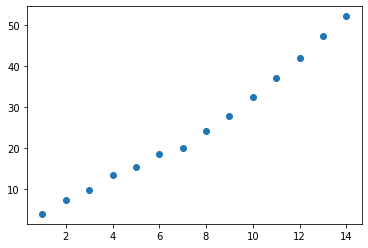

In [15]:
#sm_df.loc[:,('RPR','difRPR','Pos')].head(15)
cols =[]
for i in range(14):
    cols.append('Pos'+str(i+1))

    

rpH_df = pd.DataFrame.from_dict(RPRdicH,orient = 'index',columns = cols)
rpNH_df = pd.DataFrame.from_dict(RPRdicNH,orient = 'index',columns = cols)
means = []
for i in range(14):
    means.append(rpH_df.iloc[:,i].mean())
x = np.arange(1,15,1)

plt.scatter(x,means)
plt.show()



Text(0.5, 1.0, 'RPR difference for each positions for Non-Handicapped Races')

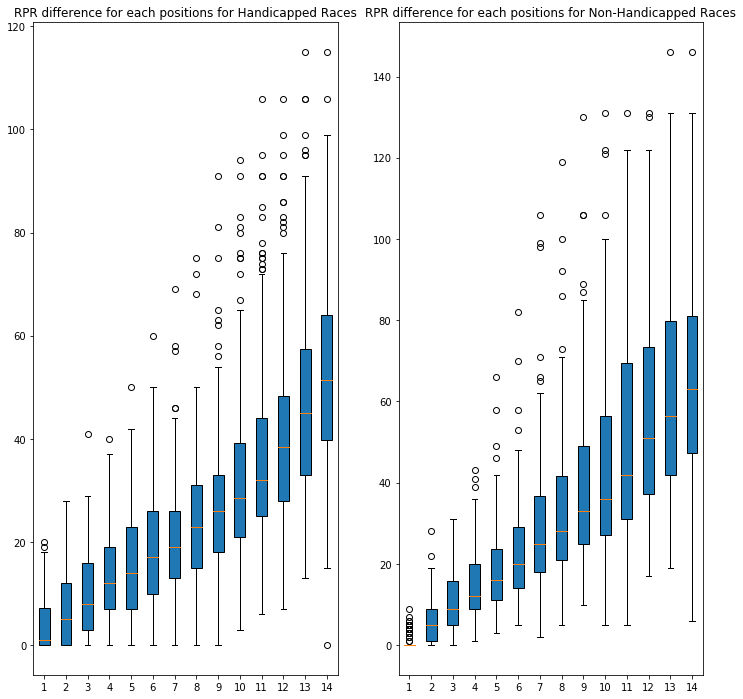

In [16]:


all_data = rpH_df.T
all_data2 = rpNH_df.T
labels = cols


fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))

# rectangular box plot
bplot1 = ax1.boxplot(all_data,
                     vert=True,  # vertical box alignment
                     patch_artist=True)
bplot2 = ax2.boxplot(all_data2,
                     vert=True,  # vertical box alignment
                     patch_artist=True)# will be used to label x-ticks
ax1.set_title('RPR difference for each positions for Handicapped Races')
ax2.set_title('RPR difference for each positions for Non-Handicapped Races')

#https://www.olbg.com/blogs/profitable-horse-racing-betting-system-racing-post-ratings-improvers


In [17]:
#dictionary return function
RPRdicH[i] = difRPR(dfr).values.tolist()
# function returns a dictionary of the groupby method
#Could be useful for future analysis

lst = ['Horse', 'Pos']
#Function makes a dictionary according the variable(s) you want to look at
#inputs are df= dataframe
#lst = which variables you want to group by
#y = which variable you want to look at specifically (must be a list) ie, ['Pos','SP']
#if y == ['all'], it will take all variable results from df
def dicmake(df,lst,y):
    ln = len(lst)
    grp = sm_df.groupby(lst).groups
    if y[0] != 'all':
        grp1 = { x:df.ix[grp[x],y].values for x in grp}
    if y[0] == 'all':
        grp1 = { x:df.ix[grp[x],:].values.tolist()[0] for x in grp}
    return grp1
#dfH = dicmake(df,lst)


In [56]:
#Need to stop the analysis work
#Need more variables in more to create a better model
#Lets start with the winning % of horse
#7486 horses 

Hg = sm_df.groupby(['Horse']).groups 
# Hg will be used often especially for horse analysis, keys = horse, values = index of the race horse ran in

#horses = Hg.mean().index.tolist()
#Creating an empty column where we will be iterating through the values
nas = np.empty((1,sm_df.shape[0]))
nas[:] = np.nan
sm_df['avgW'] = nas[0]
sm_df['avgP'] = nas[0]


Hap={}
NormP={}
#creates dictionary of keys = horse name, value = Position in each race
for key in Hg:
    Hap[key] = sm_df.loc[Hg[key],'Pos'].tolist()
    NormP[key] = sm_df.loc[Hg[key],'normPos'].tolist()
    
pn = ['2','3']
win={}
place={}
dic = Hap
for key in dic:
    value = dic[key]
    cnt = 0
    b =[]
    d=[]
    cnt2=0
    for i in range(len(value)):
        if value[i] == '1':
            cnt += 1
            cnt2 += 1
            b.append(cnt/(i+1))
            d.append(cnt2/(i+1))
        elif value[i] in pn:
            cnt2 += 1
            d.append(cnt2/(i+1))
            b.append(cnt/(i+1))
        else:
            b.append(cnt/(i+1))
            d.append(cnt2/(i+1))
    win[key]=b
    place[key]=d


    
nas = np.empty((1,sm_df.shape[0]))
nas[:] = np.nan
sm_df['avgW'] = nas[0]
sm_df['avgP'] = nas[0]
place
#Hap['A New Dawn']


{'A Delight': [0.0, 0.0],
 'A Different World': [0.0, 0.0, 0.0],
 'A Dos No Bueno': [0.0, 0.0],
 'A Few Bob Short': [1.0, 0.5, 0.3333333333333333, 0.5, 0.4],
 'A Girl Like Me': [0.0,
  0.5,
  0.3333333333333333,
  0.25,
  0.2,
  0.16666666666666666],
 'A Great View': [0.0, 0.0],
 'A Legal Beauty': [0.0, 0.0, 0.0],
 'A Likely Story': [0.0,
  0.0,
  0.0,
  0.0,
  0.2,
  0.16666666666666666,
  0.14285714285714285,
  0.125,
  0.2222222222222222,
  0.2,
  0.18181818181818182,
  0.16666666666666666,
  0.23076923076923078,
  0.2857142857142857],
 'A Mere Bagatelle': [0.0, 0.0, 0.0],
 'A New Dawn': [0.0,
  0.5,
  0.6666666666666666,
  0.5,
  0.6,
  0.6666666666666666,
  0.7142857142857143],
 'A Place Apart': [0.0, 0.0],
 'A Plus Tard': [1.0, 1.0, 1.0, 1.0],
 'A Sizing Network': [0.0],
 'A Step Too Far': [1.0,
  0.5,
  0.3333333333333333,
  0.25,
  0.2,
  0.16666666666666666,
  0.14285714285714285,
  0.125,
  0.1111111111111111,
  0.1],
 'A Three Eighty': [0.0, 0.0],
 'A Toi Phil': [0.0, 0.0, 0

In [81]:
sm_df.columns

Index(['Date', 'Off', 'Name', 'Horse', 'Pos', 'SP', 'Ran', 'Time', 'RPR',
       'Fav', 'Horse_nation', 'Handicap', 'Maiden_race', 'UID', 'true_Pos',
       'normPos', 'RprBool', 'difRPR', 'avgW', 'avgP'],
      dtype='object')

In [59]:


for key in Hg:
    index = Hg[key]
    valueW = win[key]
    valueP = place[key]
    #print(len(index),len(valueP))
    sm_df.loc[index,'avgW'] = valueW
    #print(type(sm_df.loc[index,['Horse','Pos']]))
    sm_df.loc[index,'avgP'] = valueP

#sm_df[('avgW','avgP')].head(15)



In [60]:
sm_df.loc[range(3000,3500),('Horse','avgW','avgP','Pos')]

,Horse,avgW,avgP,Pos
3000,So Enjoy,0.0,0.50,3
3001,Tashman,0.0,0.00,4
3002,Coral Blue,0.0,0.50,5
3003,Lignou,0.0,0.00,6
3004,Great Vizier,0.0,0.00,7
...,...,...,...,...
3495,Red Cymbal,0.0,0.00,6
3496,Eastern Racer,0.0,0.00,7
3497,Super Julius,0.0,0.00,8
3498,Annabelle Rock,1.0,1.00,1


In [79]:
#Want to do a expontential weighted average of normative position
#And a moving average too
#Could also do win% of last 4 runs


def ema(s, n):
    """
    returns an n period exponential moving average for
    the time series s

    s is a list ordered from oldest (index 0) to most
    recent (index -1)
    n is an integer

    returns a numeric array of the exponential
    moving average
    """
    s = np.array(s)
    ema = []
    j = 1

    #get n sma first and calculate the next n period ema
    sma = sum(s[:n]) / n
    multiplier = 2 / float(1 + n)
    ema.append(sma)

    #EMA(current) = ( (Price(current) - EMA(prev) ) x Multiplier) + EMA(prev)
    ema.append(( (s[n] - sma) * multiplier) + sma)

    #now calculate the rest of the values
    for i in s[n+1:]:
        tmp = ( (i - ema[j]) * multiplier) + ema[j]
        j = j + 1
        ema.append(tmp)
    return ema





{'A Delight': Int64Index([20514, 23066], dtype='int64'),
 'A Different World': Int64Index([26100, 27506, 30202], dtype='int64'),
 'A Dos No Bueno': Int64Index([751, 9628], dtype='int64'),
 'A Few Bob Short': Int64Index([16910, 18620, 20578, 24382, 26457], dtype='int64'),
 'A Girl Like Me': Int64Index([2283, 3408, 5300, 21977, 24125, 25181], dtype='int64'),
 'A Great View': Int64Index([28208, 31122], dtype='int64'),
 'A Legal Beauty': Int64Index([18977, 20152, 22726], dtype='int64'),
 'A Likely Story': Int64Index([ 6197,  8482, 10094, 12126, 12883, 14200, 15709, 19040, 22674,
             24256, 24839, 27425, 30113, 30470],
            dtype='int64'),
 'A Mere Bagatelle': Int64Index([16995, 18563, 21548], dtype='int64'),
 'A New Dawn': Int64Index([10385, 11924, 13790, 14015, 20305, 23329, 24771], dtype='int64'),
 'A Place Apart': Int64Index([10478, 12799], dtype='int64'),
 'A Plus Tard': Int64Index([646, 7839, 27665, 30930], dtype='int64'),
 'A Sizing Network': Int64Index([2158], dtype=

In [95]:
nas = np.empty((1,sm_df.shape[0]))
nas[:] = np.nan
sm_df['emaNormP'] = nas[0]


emaNP = {}
for key in NormP:
    index =Hg[key]
    
    r = 3
    ln = len(NormP[key])
    zs = ln - r
    if ln > r:
        ems = [0]*(r-1)
        #print(NormP[key])
        Evalue = ema(NormP[key],r)
        for i in Evalue:
            ems.append(i)
        sm_df.loc[index,'emaNormP'] = ems
        emaNP[key] = ems
        #print(len(index),len(ems))
    else:
        emaNP[key] = [0]*ln
        sm_df.loc[index,'emaNormP'] = [0]*ln
        
        #print('x',len(index),len(ems))

sm_df.loc[range(10000,10015),['normPos','emaNormP','Horse']]
#emaNP

,normPos,emaNormP,Horse
10000,4.307692,0.000000,Nan Yehi
10001,5.384615,0.000000,Magic Fountain
10002,6.461538,0.000000,Arctic Blaze
10003,7.538462,0.000000,Annie Pender
10004,8.615385,0.000000,Nanafullam
10005,9.692308,0.000000,Light Of Fire
10006,10.769231,0.000000,Amareddy
10007,11.846154,0.000000,Celtic Red
10008,12.923077,13.079153,Muirisc
10009,14.000000,0.000000,Shabra's Rock
